In [4]:
def extract_text_from_pdfs():
    # Loading Documents:
    loader = DirectoryLoader("dataset_pdf/", glob="**/*.pdf")
    documents = loader.load()

    print(documents)



In [8]:
pip install "unstructured[pdf]"

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached tokenizers-0.21.2-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   --- ------------------------------------ 1.3/15.9 MB 7.5 MB/s eta 0:00:02


  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.31.1 requires protobuf<6.0,>=5.0, but you have protobuf 6.31.1 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>

In [10]:
pip uninstall onnxruntime

^C
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install pymupdf pandas

   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.7 MB 4.2 MB/s eta 0:00:05
   -- ------------------------------------- 1.3/18.7 MB 4.0 MB/s eta 0:00:05
   ----- ---------------------------------- 2.4/18.7 MB 4.3 MB/s eta 0:00:04
   ------- -------------------------------- 3.7/18.7 MB 5.0 MB/s eta 0:00:04
   ----------- ---------------------------- 5.5/18.7 MB 5.8 MB/s eta 0:00:03
   ---------------- ----------------------- 7.6/18.7 MB 6.5 MB/s eta 0:00:02
   ---------------------- ----------------- 10.7/18.7 MB 7.8 MB/s eta 0:00:02
   ------------------------------ --------- 14.4/18.7 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------  18.6/18.7 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 18.7/18.7 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import fitz  # PyMuPDF
import pandas as pd

# Load the PDF
pdf_path = "dataset_pdf/2025SUStats.pdf"  # Replace with your path if different
doc = fitz.open(pdf_path)

# Extract all text
full_text = ""
for page in doc:
    full_text += page.get_text()

# Extract just the section between "Date" and "TEAM STATISTICS"
start_idx = full_text.find("Date")
end_idx = full_text.find("TEAM STATISTICS")
games_text = full_text[start_idx:end_idx]

# Split and clean lines
lines = [line.strip() for line in games_text.splitlines() if line.strip()]
lines_cleaned = lines[4:]  # Skip headers: "Date", "Opponent", "Score", "Att."
normalized_lines = [line.lstrip("*").strip() for line in lines_cleaned if line != "*"]

# Group every 5 lines into a match record
records = []
i = 0
while i + 4 < len(normalized_lines):
    try:
        date = normalized_lines[i]
        opponent = normalized_lines[i + 1]
        result = normalized_lines[i + 2]
        score = normalized_lines[i + 3]
        attendance = int(normalized_lines[i + 4])

        if '-' in score:
            su_score, opponent_score = map(int, score.split('-'))
        else:
            i += 1
            continue

        records.append([date, opponent, result, su_score, opponent_score, attendance])
        i += 5
    except Exception:
        i += 1  # Skip broken entries

# Create DataFrame and save to CSV
df = pd.DataFrame(records, columns=["Date", "Opponent", "Result", "SU_Score", "Opponent_Score", "Attendance"])
df.to_csv("SU_WLAX_2025_Results_AutoParsed.csv", index=False)

print("Saved to SU_WLAX_2025_Results_AutoParsed.csv")
print(df.head())


Saved to SU_WLAX_2025_Results_AutoParsed.csv
     Date              Opponent Result  SU_Score  Opponent_Score  Attendance
0  Feb 07               UALBANY      W        21               9        2127
1  Feb 15        at #7 Maryland      W        15               9         758
2  Feb 18               CORNELL      W        18              10        2214
3  Feb 22  at #2 North Carolina      L         8              16        1088
4  Feb 25       #3 NORTHWESTERN      L         8              12        2080


In [25]:
import fitz  # PyMuPDF
import pandas as pd
import re

# === Load PDF ===
doc = fitz.open("dataset_pdf/2025SUStats.pdf")  # replace with your actual path
full_text = ""
for page in doc:
    full_text += page.get_text()

# === 1. Team Record Extraction ===
record_section = full_text.split("RECORD:")[1].split("Date")[0].strip().splitlines()
record_data = [line.strip() for line in record_section if line.strip()]
record_table = {
    "Category": ["All Games", "Conference", "Non-Conference"],
    "Overall": [record_data[5], record_data[9], record_data[13]],
    "Home":    [record_data[6], record_data[10], record_data[14]],
    "Away":    [record_data[7], record_data[11], record_data[15]],
    "Neutral": [record_data[8], record_data[12], record_data[16]]
}
df_record = pd.DataFrame(record_table)
df_record.to_csv("SU_Team_Record.csv", index=False)

# === 2. Game Results Extraction ===
games_section = full_text.split("Date")[1].split("TEAM STATISTICS")[0]
lines = [line.strip() for line in games_section.splitlines() if line.strip()]
lines = lines[4:]  # Skip headers
lines = [line.lstrip("*") for line in lines if line != "*"]

# Group every 5 lines as a game
games = []
i = 0
while i + 4 < len(lines):
    try:
        date = lines[i]
        opponent = lines[i+1]
        result = lines[i+2]
        score = lines[i+3]
        attendance = int(lines[i+4])
        su_score, opp_score = map(int, score.split("-"))
        games.append([date, opponent, result, su_score, opp_score, attendance])
        i += 5
    except:
        i += 1

df_games = pd.DataFrame(games, columns=["Date", "Opponent", "Result", "SU_Score", "Opponent_Score", "Attendance"])
df_games.to_csv("SU_Game_Results.csv", index=False)

# === 3. Period Statistics Robust Parser ===
def extract_stats_block(label):
    block = full_text.split(label)[1].split("\n")
    su_stats, opp_stats = [], []
    su_found = opp_found = False

    for line in block:
        numbers = list(map(int, re.findall(r'\d+', line)))
        if "Syracuse" in line:
            su_found = True
            continue
        if "Opponents" in line:
            opp_found = True
            continue
        if su_found and not opp_found and len(su_stats) < 7:
            su_stats += numbers
        elif opp_found and len(opp_stats) < 7:
            opp_stats += numbers
        if len(su_stats) >= 7 and len(opp_stats) >= 7:
            break

    su_stats = su_stats[:7]
    opp_stats = opp_stats[:7]
    periods = ["1st", "2nd", "3rd", "4th", "OT", "OT2", "Total"]

    if len(su_stats) != 7 or len(opp_stats) != 7:
        raise ValueError(f"[ERROR] Failed to extract 7 stats for {label}. SU: {su_stats}, OPP: {opp_stats}")

    return pd.DataFrame({
        "Period": periods,
        "Syracuse": su_stats,
        "Opponents": opp_stats
    })

df_goals = extract_stats_block("Goals by Period")
df_saves = extract_stats_block("Saves by Period")
df_shots = extract_stats_block("Shots by Period")
df_sog = extract_stats_block("Shots on Goal")

df_goals.to_csv("SU_Goals_By_Period.csv", index=False)
df_saves.to_csv("SU_Saves_By_Period.csv", index=False)
df_shots.to_csv("SU_Shots_By_Period.csv", index=False)
df_sog.to_csv("SU_SOG_By_Period.csv", index=False)

print("✅ All CSVs created successfully:")
print("- SU_Team_Record.csv")
print("- SU_Game_Results.csv")
print("- SU_Goals_By_Period.csv")
print("- SU_Saves_By_Period.csv")
print("- SU_Shots_By_Period.csv")
print("- SU_SOG_By_Period.csv")


✅ All CSVs created successfully:
- SU_Team_Record.csv
- SU_Game_Results.csv
- SU_Goals_By_Period.csv
- SU_Saves_By_Period.csv
- SU_Shots_By_Period.csv
- SU_SOG_By_Period.csv


In [28]:
import pandas as pd

# ✅ Make sure this line exists:
games = pd.read_csv("SU_Game_Results.csv")

# ✅ Now this will work correctly
total_games = len(games)

# Win/Loss ratio
wins = len(games[games["Result"].str.startswith("W")])
losses = len(games[games["Result"].str.startswith("L")])
win_rate = wins / total_games

# Average score
avg_su_score = games["SU_Score"].mean()
avg_opp_score = games["Opponent_Score"].mean()

# Attendance insights
most_attended = games.sort_values("Attendance", ascending=False).head(3)

# Print summary
print(f"Games played: {total_games}, Wins: {wins}, Win %: {win_rate:.2f}")
print(f"Average SU Score: {avg_su_score:.2f}, Opponent Score: {avg_opp_score:.2f}")
print("Most attended games:\n", most_attended)



Games played: 17, Wins: 8, Win %: 0.47
Average SU Score: 11.76, Opponent Score: 11.71
Most attended games:
       Date        Opponent Result  SU_Score  Opponent_Score  Attendance
8   Mar 23  #20 NOTRE DAME      W        12              11        3622
4   Mar 01     #14 CLEMSON      L         8               9        2899
9   Mar 29    #11 VIRGINIA      W        13              12        2736


In [2]:
import pandas as pd
import os

# Load relevant CSV files
csv_files = {
    "game_results": "SU_Game_Results.csv",
    "goals_by_period": "SU_Goals_By_Period.csv",
    "saves_by_period": "SU_Saves_By_Period.csv",
    "shots_by_period": "SU_Shots_By_Period.csv",
    "sog_by_period": "SU_SOG_By_Period.csv",
    "team_record": "SU_Team_Record.csv"
}

# Load CSVs into dictionary
dataframes = {}
for key, file in csv_files.items():
    if os.path.exists(file):
        dataframes[key] = pd.read_csv(file)
    else:
        dataframes[key] = pd.DataFrame()

# Create stats summary dictionary
stats_summary = {}

# Team record stats
df_team = dataframes["team_record"]
if not df_team.empty:
    stats_summary["Total Games"] = df_team['Total Games'].sum() if 'Total Games' in df_team.columns else len(df_team)
    stats_summary["Wins"] = df_team['Wins'].sum() if 'Wins' in df_team.columns else None
    stats_summary["Losses"] = df_team['Losses'].sum() if 'Losses' in df_team.columns else None

# Goal statistics
df_goals = dataframes["goals_by_period"]
if not df_goals.empty:
    total_goals = df_goals.select_dtypes(include='number').sum().sum()
    stats_summary["Total Goals"] = total_goals
    stats_summary["Average Goals per Game"] = total_goals / len(df_goals)

# Save statistics
df_saves = dataframes["saves_by_period"]
if not df_saves.empty:
    total_saves = df_saves.select_dtypes(include='number').sum().sum()
    stats_summary["Total Saves"] = total_saves

# Shot statistics
df_shots = dataframes["shots_by_period"]
if not df_shots.empty:
    total_shots = df_shots.select_dtypes(include='number').sum().sum()
    stats_summary["Total Shots"] = total_shots
    if "Total Goals" in stats_summary:
        stats_summary["Shot Conversion Rate"] = stats_summary["Total Goals"] / total_shots

# Save percentage
if "Total Saves" in stats_summary and "Total Shots" in stats_summary:
    stats_summary["Save Percentage"] = stats_summary["Total Saves"] / stats_summary["Total Shots"]

# Convert to DataFrame and display
stats_df = pd.DataFrame(list(stats_summary.items()), columns=["Metric", "Value"])
display(stats_df)


,Metric,Value
0,Total Games,3.000000
1,Wins,NaN
2,Losses,NaN
3,Total Goals,912.000000
4,Average Goals per Game,130.285714
5,Total Saves,660.000000
6,Total Shots,2180.000000
7,Shot Conversion Rate,0.418349
8,Save Percentage,0.302752


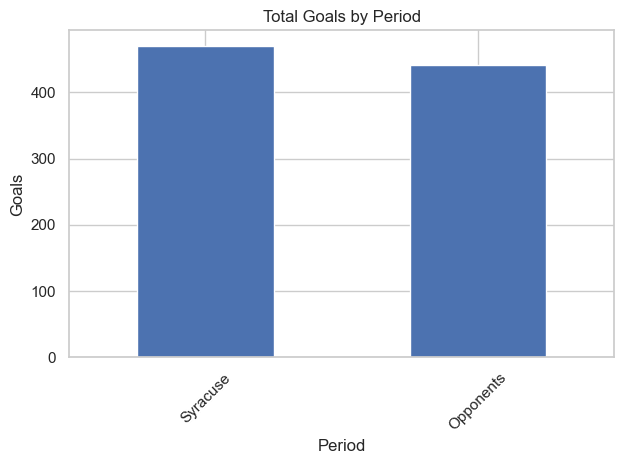

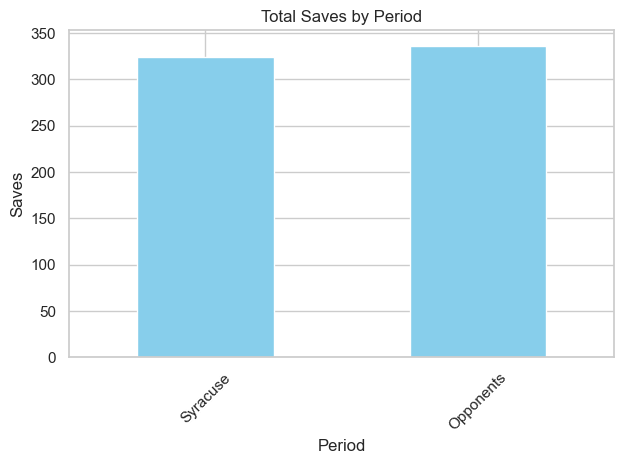

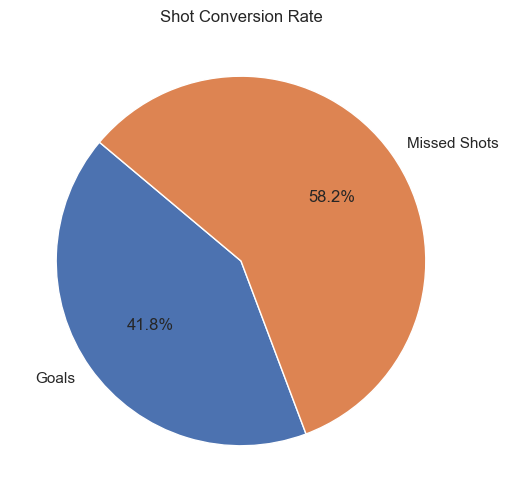

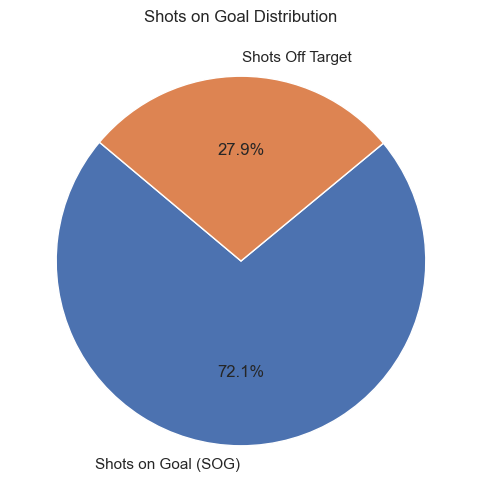

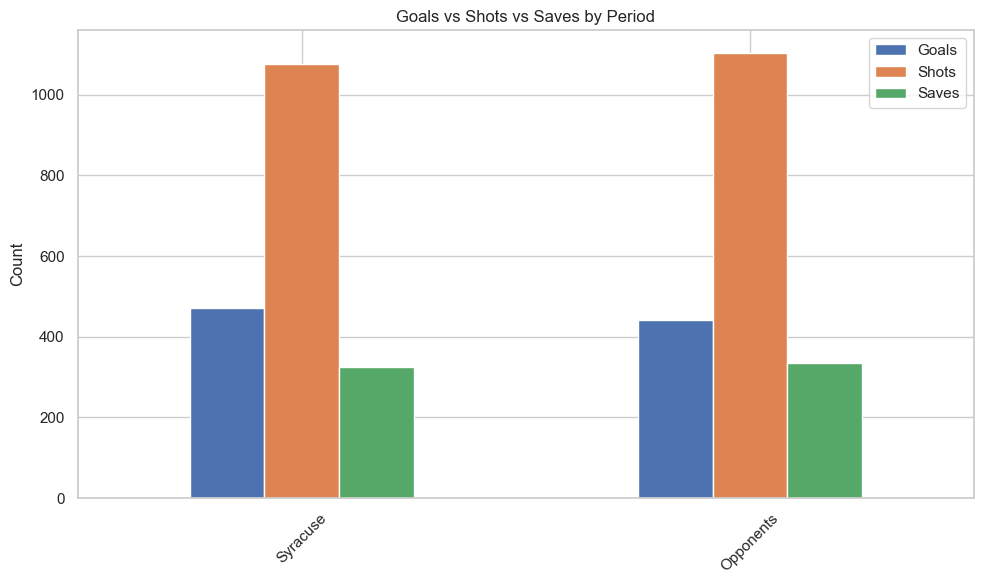

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style
sns.set(style="whitegrid")

# Load your datasets again (optional if already loaded)
goals_df = dataframes["goals_by_period"]
saves_df = dataframes["saves_by_period"]
shots_df = dataframes["shots_by_period"]
sog_df = dataframes["sog_by_period"]

# 1. Total Goals by Period
if not goals_df.empty:
    goals_by_period = goals_df.select_dtypes(include='number').sum()
    goals_by_period.plot(kind='bar', title="Total Goals by Period", ylabel="Goals", xlabel="Period")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Total Saves by Period
if not saves_df.empty:
    saves_by_period = saves_df.select_dtypes(include='number').sum()
    saves_by_period.plot(kind='bar', title="Total Saves by Period", ylabel="Saves", xlabel="Period", color='skyblue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Total Shots vs Goals
if not shots_df.empty and not goals_df.empty:
    total_shots = shots_df.select_dtypes(include='number').sum().sum()
    total_goals = goals_df.select_dtypes(include='number').sum().sum()
    labels = ['Goals', 'Missed Shots']
    values = [total_goals, total_shots - total_goals]
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Shot Conversion Rate")
    plt.show()

# 4. Shots vs SOG (Shots on Goal)
if not shots_df.empty and not sog_df.empty:
    total_shots = shots_df.select_dtypes(include='number').sum().sum()
    total_sog = sog_df.select_dtypes(include='number').sum().sum()
    labels = ['Shots on Goal (SOG)', 'Shots Off Target']
    values = [total_sog, total_shots - total_sog]
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Shots on Goal Distribution")
    plt.show()

# 5. Comparison by Period (Goals, Shots, Saves)
if not goals_df.empty and not shots_df.empty and not saves_df.empty:
    combined = pd.DataFrame({
        "Goals": goals_df.select_dtypes(include='number').sum(),
        "Shots": shots_df.select_dtypes(include='number').sum(),
        "Saves": saves_df.select_dtypes(include='number').sum()
    })
    combined.plot(kind='bar', figsize=(10, 6))
    plt.title("Goals vs Shots vs Saves by Period")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
